# Cellular automaton - Rendu Intelligence Distribuée

## Test file for experiments with many density 

##### Colin Decourt - Bordeaux INP ENSEIRB-MATMECA
Engineering student in artificial intelligence


###### Import

In [1]:
import numpy as np
import matplotlib.pyplot as plt
import os
import imageio
import datetime
import cv2 as cv
from tqdm import tqdm
import seaborn as sb
%matplotlib inline

##### Utils functions

In [2]:
def create_gif(filenames, duration, name):
    images = []
    for filename in filenames:
        images.append(imageio.imread(filename))
    output_file = 'Gif-%s.gif' % datetime.datetime.now().strftime('%Y-%M-%d-%H-%M-%S')
    imageio.mimsave('./test_data/'+name+output_file, images, duration=duration)

In [3]:
def get_neighbours_indices(forest, cell, valid_cells):
    '''
    Function which get all the valid neighbours of a given cell
    :forest: the forest grid
    :cell: cell's neighbours
    :valid_cells: all the valid coordinates of the forest grid
    '''
    X = [-1, -1, 0, 1, 1, 1, 0, -1]
    Y = [0, 1, 1, 1, 0, -1, -1, -1]
    neighbours_list = []
    
    for k in range(len(X)):
        temp_cell = (cell[0] + X[k], cell[1] + Y[k])
        if temp_cell in valid_cells:
            neighbours_list.append(temp_cell)
    return neighbours_list
            

In [4]:
def valid_cells(forest):
    '''
    Function which get all the coordinates of the grid
    :forest: the forest grid
    '''
    valid_cells = []
    for i in range(forest.shape[0]):
        for j in range(forest.shape[1]):
            valid_cells.append((i,j))
    return valid_cells

##### Parameters

In [14]:
cells = {'empty':0, 'tree1':1, 'tree2':2, 'tree3':3, 'tree4':4, 'tree5': 6, 'tree6': 7, 'tree7':8, 'tree8': 9, 'fire': 10, 'ash': 11}
density = {'tree1': 0.15, 'tree2': 0.25 , 'tree3':0.35, 'tree4': 0.45, 'tree5': 0.55, 'tree6': 0.65, 'tree7': 0.75, 'tree7':0.85, 'tree8': 0.95}

grid_size = (50, 50)

# Display parameters
pallette = np.array( [[153, 102, 0],# empty
                      [0, 51, 8],  # tree1
                      [0, 153, 25],  # tree2
                      [0, 230, 0], # tree3
                      [149, 255, 128], # tree4
                      [230, 115, 0],   # fire
                      [158, 158, 158] # ash
                      ])

In [12]:
def generate_forest(grid_size, max_start_fire):
    forest = np.zeros(grid_size, dtype=int)
    no_change = []
    num_fire = 0
    tree = 0
    exist = valid_cells(forest)
    for i in range(grid_size[0]):
        for j in range(grid_size[1]):
            if (i,j) not in no_change:
                type_cell = np.random.randint(low=0, high=17)
                if type_cell == 0:
                    # Une chance sur 30 d'avoir une clairière
                    clear = np.random.randint(low=0, high=30)
                    forest[i,j] = cells['empty']
                    if clear == 12:
                        neigh_list = get_neighbours_indices(forest, (i,j), exist)
                        for neigh in neigh_list:
                            no_change.append(neigh)
                            forest[neigh] = cells['empty']
                if type_cell == 1 or type_cell ==2:
                    forest[i,j] = cells['tree']
                    tree += 1
                    
                if type_cell == 16 and num_fire < max_start_fire:
                    forest[i,j] = cells['fire']
                    num_fire += 1
    print('Generate forest with', num_fire, 'start of fire')
    initial_forest = {'fire': num_fire, 'ash': 0, 'tree1':tree1 , 'tree2': tree2, 'tree3': tree3, 'tree4': tree4, 'tree5': tree5, 'tree6': tree6, 'tree7': tree7, 'tree8':tree8}
    return forest, initial_forest

##### Transition functions

Transition rules : 

- An empty cell stay empty
- A ash cell stay ash
- A fire cell become ash
- A tree cell :
    - Become fire if one of them neighbour is in fire
    - Stay tree otherwise

In [7]:
def may_burn(forest, cell, cell_type, state):
    to_burn = []
    no_burn = []

    neigh_list = get_neighbours_indices(forest, cell, EXIST_CELLS)
    for neigh_cell in neigh_list:
        if forest[neigh_cell] == cells['fire']:
            to_burn.append(neigh_cell)       
        else:
            no_burn.append(neigh_cell)
    seuil = np.random.random()
    if to_burn == [] or seuil > density[cell_type]:
        return cells[cell_type], state
    else:
        state[cell_type]-=1
        state['fire'] += 1
        return cells['fire'], state

In [8]:
def transition_general(forest, cell, state):
    '''
    Function which return the future state of a given cell
    :forest: the forest grid
    :cell: cell's future state wanted
    :state: state of the country at current step
    '''
    try:
        if forest[cell] == cells['empty']:
            return cells['empty'], state

        if forest[cell] == cells['ash']:
            return cells['ash'], state

        if forest[cell] == cells['tree1']:
            return may_burn(forest, cell, 'tree1', state)

        if forest[cell] == cells['tree2']:
            return may_burn(forest, cell, 'tree2', state)

        if forest[cell] == cells['tree3']:
            return may_burn(forest, cell, 'tree3', state)

        if forest[cell] == cells['tree4']:
            return may_burn(forest, cell, 'tree4', state)
        
        if forest[cell] == cells['tree5']:
            return may_burn(forest, cell, 'tree4', state)
        
        if forest[cell] == cells['tree6']:
            return may_burn(forest, cell, 'tree8', state)
        
        if forest[cell] == cells['tree7']:
            return may_burn(forest, cell, 'tree8', state)
        
        if forest[cell] == cells['tree8']:
            return may_burn(forest, cell, 'tree8', state)

        if forest[cell] == cells['fire']:
            state['fire']-=1
            state['ash'] +=1
            return cells['ash'], state
        
    except:
        print('Unknown cell type. Abort.')
    
    

##### Fire propagation

In [9]:
def step(forest, is_fire, state):
    '''
    Function which perfom one propagation step
    :forest: the forest grid
    :is_fire: boolean informing the fire state - True : still cell in fire False otherwise
    '''
    nb_fire = 0
    new_forest = forest.copy()
    new_state = state.copy()
    for i in range(forest.shape[0]):
        for j in range(forest.shape[1]):
            cell_type, new_state = transition_general(forest, (i,j), new_state)
            new_forest[i,j] = cell_type
            if new_forest[i,j] == cells['fire']:
                nb_fire += 1
    print(nb_fire)
    if nb_fire == 0:
        is_fire = False
    return new_forest, is_fire, new_state

In [10]:
# Reset images
for name in os.listdir():
    if name[-3:] == 'png':
        if name != 'aust-veg-map.png':
            os.remove(name)

## Fire forest on random grid

In [16]:
grid_list = [(10,10), (20, 20), (30, 30), (40, 40), (50, 50), (100, 100)]
for grid_size in grid_list:
    forest, initial_state = generate_forest(grid_size, 100)
    EXIST_CELLS = valid_cells(forest)
    is_fire = True
    state_list =[]
    state_list.append(initial_state)
    num_step = 0
    plt.figure(figsize=(10,10))
    plt.imshow(forest)
    plt.savefig(str(num_step)+'.png')
    plt.clf()
    while(1):
        print('--- STEP',num_step,'begin ---')
        forest, is_fire, state = step(forest, is_fire, state_list[num_step])
        print('New state:',state)
        state_list.append(state.copy())
        num_step+=1
        plt.figure(figsize=(10,10))
        plt.imshow(forest)
        plt.savefig(str(num_step)+'.png')
        plt.clf()
        if is_fire is False:
            print('Fire is dead...')
            break
    np.save('./test_data/state_list_'+str(grid_size), state_list)
    filenames = []
    for name in os.listdir():
        if name[-3:] == 'png':
            if name != 'aust-veg-map.png':
                filenames.append(name)
    filenames.sort(key=lambda x: float(x[:-4]))

    create_gif(filenames, duration=0.8, name=str(grid_size))
    # Reset images
    for name in os.listdir():
        if name[-3:] == 'png':
            if name != 'aust-veg-map.png':
                os.remove(name)

Generate forest with 6 start of fire
--- STEP 0 begin ---
25
New state: {'fire': 25, 'ash': 6, 'tree1': 11, 'tree2': 8, 'tree3': 5, 'tree4': 7, 'tree5': 16, 'tree6': 15, 'tree7': 9, 'tree8': -1}
--- STEP 1 begin ---
17
New state: {'fire': 17, 'ash': 31, 'tree1': 10, 'tree2': 7, 'tree3': 3, 'tree4': 5, 'tree5': 16, 'tree6': 15, 'tree7': 9, 'tree8': -12}
--- STEP 2 begin ---
13
New state: {'fire': 13, 'ash': 48, 'tree1': 10, 'tree2': 4, 'tree3': 3, 'tree4': 1, 'tree5': 16, 'tree6': 15, 'tree7': 9, 'tree8': -18}
--- STEP 3 begin ---
14
New state: {'fire': 14, 'ash': 61, 'tree1': 9, 'tree2': 3, 'tree3': 2, 'tree4': -8, 'tree5': 16, 'tree6': 15, 'tree7': 9, 'tree8': -20}
--- STEP 4 begin ---
5
New state: {'fire': 5, 'ash': 75, 'tree1': 9, 'tree2': 3, 'tree3': 1, 'tree4': -8, 'tree5': 16, 'tree6': 15, 'tree7': 9, 'tree8': -24}
--- STEP 5 begin ---
2
New state: {'fire': 2, 'ash': 80, 'tree1': 8, 'tree2': 3, 'tree3': 1, 'tree4': -9, 'tree5': 16, 'tree6': 15, 'tree7': 9, 'tree8': -24}
--- STEP 

/Users/cdecourt/anaconda3/envs/ia/lib/python3.7/site-packages/ipykernel_launcher.py:9: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warning`).
  if __name__ == '__main__':


159
New state: {'fire': 159, 'ash': 54, 'tree1': 107, 'tree2': 104, 'tree3': 90, 'tree4': 61, 'tree5': 91, 'tree6': 90, 'tree7': 122, 'tree8': -4}


/Users/cdecourt/anaconda3/envs/ia/lib/python3.7/site-packages/ipykernel_launcher.py:19: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warning`).


--- STEP 1 begin ---
141
New state: {'fire': 141, 'ash': 213, 'tree1': 98, 'tree2': 90, 'tree3': 73, 'tree4': 46, 'tree5': 91, 'tree6': 90, 'tree7': 122, 'tree8': -90}
--- STEP 2 begin ---
120
New state: {'fire': 120, 'ash': 354, 'tree1': 85, 'tree2': 70, 'tree3': 61, 'tree4': 21, 'tree5': 91, 'tree6': 90, 'tree7': 122, 'tree8': -140}
--- STEP 3 begin ---
107
New state: {'fire': 107, 'ash': 474, 'tree1': 75, 'tree2': 58, 'tree3': 41, 'tree4': -3, 'tree5': 91, 'tree6': 90, 'tree7': 122, 'tree8': -181}
--- STEP 4 begin ---
63
New state: {'fire': 63, 'ash': 581, 'tree1': 69, 'tree2': 51, 'tree3': 31, 'tree4': -23, 'tree5': 91, 'tree6': 90, 'tree7': 122, 'tree8': -201}
--- STEP 5 begin ---
35
New state: {'fire': 35, 'ash': 644, 'tree1': 63, 'tree2': 48, 'tree3': 24, 'tree4': -34, 'tree5': 91, 'tree6': 90, 'tree7': 122, 'tree8': -209}
--- STEP 6 begin ---
16
New state: {'fire': 16, 'ash': 679, 'tree1': 61, 'tree2': 44, 'tree3': 22, 'tree4': -39, 'tree5': 91, 'tree6': 90, 'tree7': 122, 'tree

21
New state: {'fire': 21, 'ash': 1818, 'tree1': 158, 'tree2': 104, 'tree3': 79, 'tree4': -72, 'tree5': 315, 'tree6': 274, 'tree7': 266, 'tree8': -524}
--- STEP 23 begin ---
12
New state: {'fire': 12, 'ash': 1839, 'tree1': 155, 'tree2': 104, 'tree3': 77, 'tree4': -74, 'tree5': 315, 'tree6': 274, 'tree7': 266, 'tree8': -529}
--- STEP 24 begin ---
10
New state: {'fire': 10, 'ash': 1851, 'tree1': 155, 'tree2': 103, 'tree3': 76, 'tree4': -77, 'tree5': 315, 'tree6': 274, 'tree7': 266, 'tree8': -534}
--- STEP 25 begin ---
6
New state: {'fire': 6, 'ash': 1861, 'tree1': 154, 'tree2': 102, 'tree3': 75, 'tree4': -78, 'tree5': 315, 'tree6': 274, 'tree7': 266, 'tree8': -536}
--- STEP 26 begin ---
5
New state: {'fire': 5, 'ash': 1867, 'tree1': 154, 'tree2': 101, 'tree3': 74, 'tree4': -81, 'tree5': 315, 'tree6': 274, 'tree7': 266, 'tree8': -536}
--- STEP 27 begin ---
0
New state: {'fire': 0, 'ash': 1872, 'tree1': 154, 'tree2': 101, 'tree3': 74, 'tree4': -81, 'tree5': 315, 'tree6': 274, 'tree7': 266,

71
New state: {'fire': 73, 'ash': 3817, 'tree1': 967, 'tree2': 736, 'tree3': 666, 'tree4': 369, 'tree5': 1179, 'tree6': 1090, 'tree7': 1214, 'tree8': -729}
--- STEP 41 begin ---
81
New state: {'fire': 83, 'ash': 3888, 'tree1': 960, 'tree2': 732, 'tree3': 657, 'tree4': 351, 'tree5': 1179, 'tree6': 1090, 'tree7': 1214, 'tree8': -772}
--- STEP 42 begin ---
81
New state: {'fire': 83, 'ash': 3969, 'tree1': 953, 'tree2': 721, 'tree3': 650, 'tree4': 331, 'tree5': 1179, 'tree6': 1090, 'tree7': 1214, 'tree8': -808}
--- STEP 43 begin ---
70
New state: {'fire': 72, 'ash': 4050, 'tree1': 947, 'tree2': 714, 'tree3': 643, 'tree4': 310, 'tree5': 1179, 'tree6': 1090, 'tree7': 1214, 'tree8': -837}
--- STEP 44 begin ---
67
New state: {'fire': 69, 'ash': 4120, 'tree1': 940, 'tree2': 711, 'tree3': 631, 'tree4': 292, 'tree5': 1179, 'tree6': 1090, 'tree7': 1214, 'tree8': -864}
--- STEP 45 begin ---
63
New state: {'fire': 65, 'ash': 4187, 'tree1': 936, 'tree2': 703, 'tree3': 624, 'tree4': 281, 'tree5': 1179,

50
New state: {'fire': 52, 'ash': 6969, 'tree1': 680, 'tree2': 419, 'tree3': 296, 'tree4': -302, 'tree5': 1179, 'tree6': 1090, 'tree7': 1214, 'tree8': -2215}
--- STEP 87 begin ---
31
New state: {'fire': 33, 'ash': 7019, 'tree1': 679, 'tree2': 413, 'tree3': 293, 'tree4': -307, 'tree5': 1179, 'tree6': 1090, 'tree7': 1214, 'tree8': -2231}
--- STEP 88 begin ---
19
New state: {'fire': 21, 'ash': 7050, 'tree1': 676, 'tree2': 413, 'tree3': 291, 'tree4': -311, 'tree5': 1179, 'tree6': 1090, 'tree7': 1214, 'tree8': -2241}
--- STEP 89 begin ---
12
New state: {'fire': 14, 'ash': 7069, 'tree1': 675, 'tree2': 412, 'tree3': 288, 'tree4': -314, 'tree5': 1179, 'tree6': 1090, 'tree7': 1214, 'tree8': -2245}
--- STEP 90 begin ---
9
New state: {'fire': 11, 'ash': 7081, 'tree1': 674, 'tree2': 411, 'tree3': 287, 'tree4': -317, 'tree5': 1179, 'tree6': 1090, 'tree7': 1214, 'tree8': -2248}
--- STEP 91 begin ---
5
New state: {'fire': 7, 'ash': 7090, 'tree1': 674, 'tree2': 411, 'tree3': 287, 'tree4': -320, 'tree5

<Figure size 720x720 with 0 Axes>

<Figure size 720x720 with 0 Axes>

<Figure size 720x720 with 0 Axes>

<Figure size 720x720 with 0 Axes>

<Figure size 720x720 with 0 Axes>

<Figure size 720x720 with 0 Axes>

<Figure size 720x720 with 0 Axes>

<Figure size 720x720 with 0 Axes>

<Figure size 720x720 with 0 Axes>

<Figure size 720x720 with 0 Axes>

<Figure size 720x720 with 0 Axes>

<Figure size 720x720 with 0 Axes>

<Figure size 720x720 with 0 Axes>

<Figure size 720x720 with 0 Axes>

<Figure size 720x720 with 0 Axes>

<Figure size 720x720 with 0 Axes>

<Figure size 720x720 with 0 Axes>

<Figure size 720x720 with 0 Axes>

<Figure size 720x720 with 0 Axes>

<Figure size 720x720 with 0 Axes>

<Figure size 720x720 with 0 Axes>

<Figure size 720x720 with 0 Axes>

<Figure size 720x720 with 0 Axes>

<Figure size 720x720 with 0 Axes>

<Figure size 720x720 with 0 Axes>

<Figure size 720x720 with 0 Axes>

<Figure size 720x720 with 0 Axes>

<Figure size 720x720 with 0 Axes>

<Figure size 720x720 with 0 Axes>

<Figure size 720x720 with 0 Axes>

<Figure size 720x720 with 0 Axes>

<Figure size 720x720 with 0 Axes>

<Figure size 720x720 with 0 Axes>

<Figure size 720x720 with 0 Axes>

<Figure size 720x720 with 0 Axes>

<Figure size 720x720 with 0 Axes>

<Figure size 720x720 with 0 Axes>

<Figure size 720x720 with 0 Axes>

<Figure size 720x720 with 0 Axes>

<Figure size 720x720 with 0 Axes>

<Figure size 720x720 with 0 Axes>

<Figure size 720x720 with 0 Axes>

<Figure size 720x720 with 0 Axes>

<Figure size 720x720 with 0 Axes>

<Figure size 720x720 with 0 Axes>

<Figure size 720x720 with 0 Axes>

<Figure size 720x720 with 0 Axes>

<Figure size 720x720 with 0 Axes>

<Figure size 720x720 with 0 Axes>

<Figure size 720x720 with 0 Axes>

<Figure size 720x720 with 0 Axes>

<Figure size 720x720 with 0 Axes>

<Figure size 720x720 with 0 Axes>

<Figure size 720x720 with 0 Axes>

<Figure size 720x720 with 0 Axes>

<Figure size 720x720 with 0 Axes>

<Figure size 720x720 with 0 Axes>

<Figure size 720x720 with 0 Axes>

<Figure size 720x720 with 0 Axes>

<Figure size 720x720 with 0 Axes>

<Figure size 720x720 with 0 Axes>

<Figure size 720x720 with 0 Axes>

<Figure size 720x720 with 0 Axes>

<Figure size 720x720 with 0 Axes>

<Figure size 720x720 with 0 Axes>

<Figure size 720x720 with 0 Axes>

<Figure size 720x720 with 0 Axes>

<Figure size 720x720 with 0 Axes>

<Figure size 720x720 with 0 Axes>

<Figure size 720x720 with 0 Axes>

<Figure size 720x720 with 0 Axes>

<Figure size 720x720 with 0 Axes>

<Figure size 720x720 with 0 Axes>

<Figure size 720x720 with 0 Axes>

<Figure size 720x720 with 0 Axes>

<Figure size 720x720 with 0 Axes>

<Figure size 720x720 with 0 Axes>

<Figure size 720x720 with 0 Axes>

<Figure size 720x720 with 0 Axes>

<Figure size 720x720 with 0 Axes>

<Figure size 720x720 with 0 Axes>

<Figure size 720x720 with 0 Axes>

<Figure size 720x720 with 0 Axes>

<Figure size 720x720 with 0 Axes>

<Figure size 720x720 with 0 Axes>

<Figure size 720x720 with 0 Axes>

<Figure size 720x720 with 0 Axes>

<Figure size 720x720 with 0 Axes>

<Figure size 720x720 with 0 Axes>

<Figure size 720x720 with 0 Axes>

<Figure size 720x720 with 0 Axes>

<Figure size 720x720 with 0 Axes>

<Figure size 720x720 with 0 Axes>

<Figure size 720x720 with 0 Axes>

<Figure size 720x720 with 0 Axes>

<Figure size 720x720 with 0 Axes>

<Figure size 720x720 with 0 Axes>

<Figure size 720x720 with 0 Axes>

<Figure size 720x720 with 0 Axes>

<Figure size 720x720 with 0 Axes>

<Figure size 720x720 with 0 Axes>

<Figure size 720x720 with 0 Axes>

<Figure size 720x720 with 0 Axes>

<Figure size 720x720 with 0 Axes>

<Figure size 720x720 with 0 Axes>

<Figure size 720x720 with 0 Axes>

<Figure size 720x720 with 0 Axes>

<Figure size 720x720 with 0 Axes>

<Figure size 720x720 with 0 Axes>

<Figure size 720x720 with 0 Axes>

<Figure size 720x720 with 0 Axes>

<Figure size 720x720 with 0 Axes>

<Figure size 720x720 with 0 Axes>

<Figure size 720x720 with 0 Axes>

<Figure size 720x720 with 0 Axes>

<Figure size 720x720 with 0 Axes>

<Figure size 720x720 with 0 Axes>

<Figure size 720x720 with 0 Axes>

<Figure size 720x720 with 0 Axes>

<Figure size 720x720 with 0 Axes>

<Figure size 720x720 with 0 Axes>

<Figure size 720x720 with 0 Axes>

<Figure size 720x720 with 0 Axes>

<Figure size 720x720 with 0 Axes>

<Figure size 720x720 with 0 Axes>

<Figure size 720x720 with 0 Axes>

<Figure size 720x720 with 0 Axes>

<Figure size 720x720 with 0 Axes>

<Figure size 720x720 with 0 Axes>

<Figure size 720x720 with 0 Axes>

<Figure size 720x720 with 0 Axes>

<Figure size 720x720 with 0 Axes>

<Figure size 720x720 with 0 Axes>

<Figure size 720x720 with 0 Axes>

<Figure size 720x720 with 0 Axes>

<Figure size 720x720 with 0 Axes>

<Figure size 720x720 with 0 Axes>

<Figure size 720x720 with 0 Axes>

<Figure size 720x720 with 0 Axes>

<Figure size 720x720 with 0 Axes>

<Figure size 720x720 with 0 Axes>

<Figure size 720x720 with 0 Axes>

<Figure size 720x720 with 0 Axes>

<Figure size 720x720 with 0 Axes>

<Figure size 720x720 with 0 Axes>

<Figure size 720x720 with 0 Axes>

<Figure size 720x720 with 0 Axes>

<Figure size 720x720 with 0 Axes>

<Figure size 720x720 with 0 Axes>

<Figure size 720x720 with 0 Axes>

<Figure size 720x720 with 0 Axes>

<Figure size 720x720 with 0 Axes>

<Figure size 720x720 with 0 Axes>

<Figure size 720x720 with 0 Axes>

<Figure size 720x720 with 0 Axes>

<Figure size 720x720 with 0 Axes>

<Figure size 720x720 with 0 Axes>

<Figure size 720x720 with 0 Axes>

<Figure size 720x720 with 0 Axes>

<Figure size 720x720 with 0 Axes>

<Figure size 720x720 with 0 Axes>

<Figure size 720x720 with 0 Axes>

<Figure size 720x720 with 0 Axes>

<Figure size 720x720 with 0 Axes>

<Figure size 720x720 with 0 Axes>

<Figure size 720x720 with 0 Axes>

<Figure size 720x720 with 0 Axes>

<Figure size 720x720 with 0 Axes>

<Figure size 720x720 with 0 Axes>

<Figure size 720x720 with 0 Axes>

<Figure size 720x720 with 0 Axes>

<Figure size 720x720 with 0 Axes>

<Figure size 720x720 with 0 Axes>

<Figure size 720x720 with 0 Axes>

<Figure size 720x720 with 0 Axes>

<Figure size 720x720 with 0 Axes>

<Figure size 720x720 with 0 Axes>

### Data analyse

In [17]:
density_val = [0.15, 0.25, 0.35, 0.45, 0.55, 0.65, 0.75, 0.85]

In [21]:
def get_data(data):
    fire_list = []
    tree1_list = []
    ash_list = []
    tree2_list = []
    tree3_list = []
    tree4_list = []
    tree5_list = []
    tree6_list = []
    tree7_list = []
    tree8_list = []
    for i in range(len(data)):
        fire_list.append(data[i]['fire'])
        tree1_list.append(data[i]['tree1'])
        ash_list.append(data[i]['ash'])
        tree2_list.append(data[i]['tree2'])
        tree3_list.append(data[i]['tree3'])
        tree4_list.append(data[i]['tree4'])
        tree5_list.append(data[i]['tree5'])
        tree4_list.append(data[i]['tree6'])
        tree4_list.append(data[i]['tree7'])
        tree4_list.append(data[i]['tree8'])
    return tree1_list, tree2_list, tree3_list, tree4_list, tree5_list, tree6_list, tree7_list, tree8_list, fire_list, ash_list

In [38]:
def get_burned_trees(tree_list):
    if tree_list == []:
        return 0
    else:
        burn_list = (tree_list[0]-tree_list[-1])*100/tree_list[0]
    return burn_list

def get_remain_trees(tree_list):
    if tree_list == []:
        return 0
    else:
        remain_list = (tree_list[-1])*100/tree_list[0]
    return remain_list

In [24]:
grid10 = get_data(np.load('test_data/state_list_(10, 10).npy', allow_pickle=True))
grid20 = get_data(np.load('test_data/state_list_(20, 20).npy', allow_pickle=True))
grid30 = get_data(np.load('test_data/state_list_(30, 30).npy', allow_pickle=True))
grid40 = get_data(np.load('test_data/state_list_(40, 40).npy', allow_pickle=True))
grid50 = get_data(np.load('test_data/state_list_(50, 50).npy', allow_pickle=True))
grid100 = get_data(np.load('test_data/state_list_(100, 100).npy', allow_pickle=True))


In [32]:
burn_trees10

[38.46153846153846, 66.66666666666667, 87.5, 340.0]

In [36]:
burn_trees10 = [get_burned_trees(grid10[i]) for i in range(8)]
burn_trees20 = [get_burned_trees(grid20[i]) for i in range(8)]
burn_trees30 = [get_burned_trees(grid30[i]) for i in range(8)]
burn_trees40 = [get_burned_trees(grid40[i]) for i in range(8)]
burn_trees50 = [get_burned_trees(grid50[i]) for i in range(8)]
burn_trees100 = [get_burned_trees(grid100[i]) for i in range(8)]

In [39]:
rem_trees10 = [get_remain_trees(grid10[i]) for i in range(8)]
rem_trees20 = [get_remain_trees(grid20[i]) for i in range(8)]
rem_trees30 = [get_remain_trees(grid30[i]) for i in range(8)]
rem_trees40 = [get_remain_trees(grid40[i]) for i in range(8)]
rem_trees50 = [get_remain_trees(grid50[i]) for i in range(8)]
rem_trees100 = [get_remain_trees(grid100[i]) for i in range(8)]

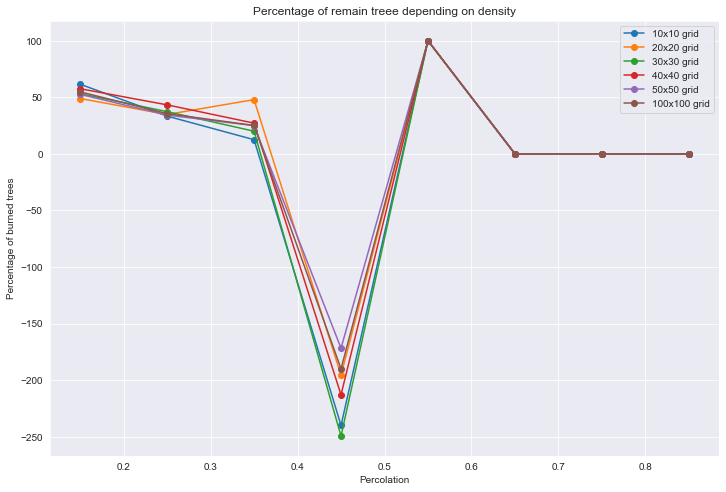

In [40]:
plt.figure(figsize=(12,8))
sb.set_style('darkgrid')
plt.plot(density_val, rem_trees10, '-o')
plt.plot(density_val, rem_trees20, '-o')
plt.plot(density_val, rem_trees30, '-o')
plt.plot(density_val, rem_trees40, '-o')
plt.plot(density_val, rem_trees50, '-o')
plt.plot(density_val, rem_trees100, '-o')
plt.xlabel('Percolation')
plt.ylabel('Percentage of burned trees')
plt.title('Percentage of remain treee depending on density')
plt.legend(('10x10 grid', '20x20 grid', '30x30 grid', '40x40 grid', '50x50 grid', '100x100 grid'))
plt.savefig('./data/remain_tree_density.png')
plt.show()

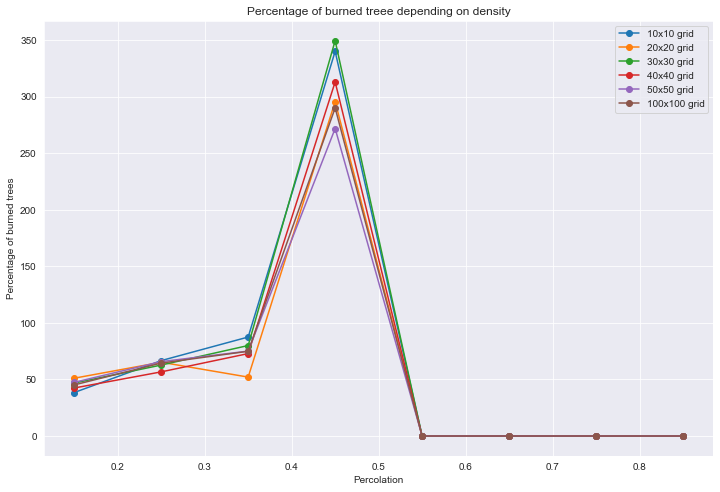

In [41]:
plt.figure(figsize=(12,8))
sb.set_style('darkgrid')
plt.plot(density_val, burn_trees10, '-o')
plt.plot(density_val, burn_trees20, '-o')
plt.plot(density_val, burn_trees30, '-o')
plt.plot(density_val, burn_trees40, '-o')
plt.plot(density_val, burn_trees50, '-o')
plt.plot(density_val, burn_trees100, '-o')
plt.xlabel('Percolation')
plt.ylabel('Percentage of burned trees')
plt.title('Percentage of burned treee depending on density')
plt.legend(('10x10 grid', '20x20 grid', '30x30 grid', '40x40 grid', '50x50 grid', '100x100 grid'))
plt.savefig('./data/burned_tree_density.png')
plt.show()